# initial rotate H or S func.
HEX(a=2.504, c=30)
  Variant name: HEX
  Special point names: GMKALH
  Default path: GMKGALHA,LM,KH

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    M   0.5000  0.0000  0.0000
    K   0.3333  0.3333  0.0000
    A   0.0000  0.0000  0.5000
    L   0.5000  0.0000  0.5000
    H   0.3333  0.3333  0.5000



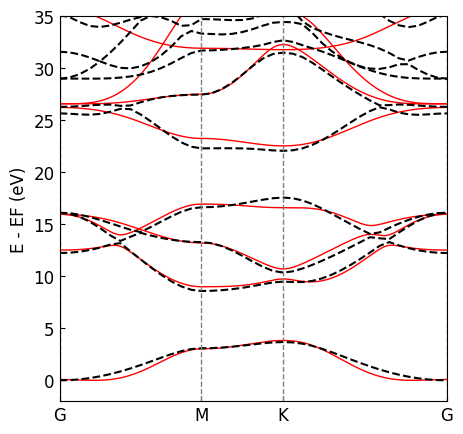

In [8]:
import torch
from dptb.nnops.nnapi import NNSK
from dptb.structure.structure import BaseStruct
from dptb.dataprocess.datareader import read_data
import matplotlib.pyplot as plt
import pickle as pickle
import numpy as np


if __name__ == '__main__':
    checkpointPath = "/root/dptb_exp/hBN/checkpoint/latest_nnsk.pth"
    train_data_path = "/root/dptb_exp/hBN/data/"
    train_data_prefix = "set"

    proj_atom_neles = {"N": 5, "B": 3}
    proj_anglr_m = {
      "N": [
        "2s",
        "2p",
        "s*"
      ],
      "B": [
        "2s",
        "2p",
        "s*"
      ]
    }
    nnsk = NNSK(checkpointPath, proj_anglr_m)
    band = pickle.load(open('./TBmodel/hBN/check/band_structure.pickle', 'rb'))

    filename = './TBmodel/hBN/check/hBN.vasp'
    st = BaseStruct(atom=filename, format='vasp',
                    cutoff=1.5, proj_atom_anglr_m=proj_anglr_m, proj_atom_neles=proj_atom_neles, onsitemode='uniform', onsite_strain="powerlaw")

    snapase = st.struct
    # snapase = structase
    lat = snapase.cell.get_bravais_lattice()
    print(lat.description())
    # lat.plot_bz(show=True)
    special_kp = lat.get_special_points()
    # spmap['M'] = np.array([0.5,0.5,1])
    # kpath=snapase.cell.bandpath('XGX', npoints=120)
    kpath = snapase.cell.bandpath('GMKG', npoints=400)
    xlist, high_sym_kpoints, labels = kpath.get_linear_kpoint_axis()
    klist = kpath.kpts
    
    all_bonds, hamil_blocks, overlap_blocks = nnsk.get_HR(st)
    hkmat, skmat = nnsk.get_HK([klist[0]])

    eigks, EF = nnsk.get_eigenvalues(klist)

    plt.figure(figsize=(5, 5), dpi=100)
    for i in range(eigks.shape[1]):
        plt.plot(xlist, eigks[:, i] - np.min(eigks), 'r-', lw=1)

    for ib in range(band['eigenvalues'].shape[1]):
        plt.plot(band['xcoords'], band['eigenvalues'][:, ib] - np.min(band['eigenvalues']), 'k--')
    # plt.plot(band['xcoords'],band['eigenvalues'][:,0] - EF,'k--',label='GPAW')

    for ii in high_sym_kpoints:
        plt.axvline(ii, color='gray', lw=1, ls='--')
    plt.tick_params(direction='in')
    plt.ylim(-2, 35)
    plt.xlim(xlist.min(), xlist.max())
    plt.ylabel('E - EF (eV)', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(high_sym_kpoints, labels, fontsize=12)
    plt.show()

